# IE4424 Lab CNN Exercise

## Acknowledgment

This lab experiment is modified based on the Pytorch official tutorial.

You can check the Pytorch official tutorial at https://pytorch.org/tutorials/



## 1. Training a classifier

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

For this part, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

We will do the following steps in order:

1) Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
   
2) Define a Convolutional Neural Network

3) Define a loss function

4) Train the network on the training data

5) Test the network on the test data

In [3]:
%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#2024 modification CPU > GPU
print("Using device:", device)#2024 modification CPU > GPU

Using device: cpu


### 1.1 Loading and normalizing CIFAR10


Using ``torchvision``, it is easy to load CIFAR10.

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified



### 1.2 Visualizing the training images


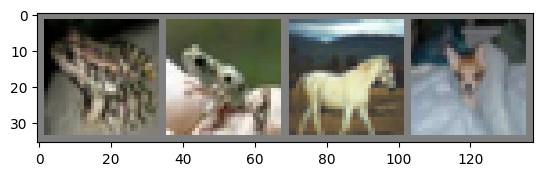

 frog  frog horse   dog


In [7]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
# images, labels = dataiter.next() # Use this in pytorch 1.12
images, labels = next(dataiter) # Use this in pytorch 1.13

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 1.3 Getting samples from dataloader

In [8]:
dataiter = iter(trainloader)
# images, labels = dataiter.next() # Use this in pytorch 1.12
images, labels = next(dataiter) # Use this in pytorch 1.13
np.shape(images[0])

torch.Size([3, 32, 32])

### 1.4 Defining a Convolutional Neural Network



In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)  #2024 modification CPU > GPU

### 1.5 Printing the network structure

In [10]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 1.6 Using Torchsummary to visualize shape of the feature maps in each layer

In [12]:
from torchsummary import summary
summary(net, input_size=(3, 32, 32)) # Here the input size is channel x width x height

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 16, 16, 16]             880
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Linear-5                  [-1, 120]         123,000
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 135,062
Trainable params: 135,062
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.52
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


### 1.7 Defining loss function and optimizer

The loss function here is defined as a Classification Cross-Entropy loss and SGD with momentum.



In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1.8 Training the network

We loop over our data iterator, and feed the inputs to the
network and optimize the parameters.



In [14]:
t1 = time.time()
loss_list = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)#2024 modification CPU > GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list.append(running_loss/2000)
            running_loss = 0.0

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

[1,  2000] loss: 2.169
[1,  4000] loss: 1.816
[1,  6000] loss: 1.623
[1,  8000] loss: 1.503
[1, 10000] loss: 1.440
[1, 12000] loss: 1.340
[2,  2000] loss: 1.257
[2,  4000] loss: 1.241
[2,  6000] loss: 1.178
[2,  8000] loss: 1.173
[2, 10000] loss: 1.133
[2, 12000] loss: 1.136
Finished Training
Training time:57.5419979095459
